In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

In [18]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

# boolean variable that indicates whether or not we have gpu...
use_cuda = torch.cuda.is_available()
print("Use GPU: {}".format(use_cuda))

# Default gaussian mixture parameters
PI = 0.5

SIGMA_1 = torch.tensor([math.exp(-0)])
SIGMA_2 = torch.tensor([math.exp(-6)])

# place tensor in GPU if use_cuda
if use_cuda:
  SIGMA_1 = SIGMA_1.cuda()
  SIGMA_2 = SIGMA_2.cuda()

# Default gaussian parameters
MU_PRIOR = 0
SIGMA_PRIOR = torch.tensor([math.exp(-0)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA_PRIOR = SIGMA_PRIOR.cuda()

# Initial weight hyperparameters
MU_WEIGHTS = (-0.03, 0.03)
RHO_WEIGHTS = (-4.31, -3.5)
MU_BIAS = (-0.03, 0.03)
RHO_BIAS = (-4.31, -3.5)

# Loss variance for regression
SIGMA = torch.tensor([math.exp(-1)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA = SIGMA.cuda()

class PriorType(Enum):
  MIXTURE = 1
  GAUSSIAN = 2

class ActivationType(Enum):
  NONE = 0
  RELU = 1
  SOFTMAX = 2
  TANH = 3
  SIGMOID = 4

class TaskType(Enum):
  REGRESSION = 1
  CLASSIFICATION = 2

class GaussianMixture(object):

  def __init__(self, pi, sigma1, sigma2):
    self.pi = pi
    self.sigma1 = sigma1
    self.sigma2 = sigma2

  # arguments of dist.Normal() should be tensors rather than scalars
  def log_prob(self, weights):
    new_weights = weights.view(-1)
    normal_density1 = dist.Normal(0,self.sigma1).log_prob(new_weights)
    exp_normal_density1 = torch.exp(normal_density1)
    exp_normal_density2 = torch.exp(
        dist.Normal(0.0, self.sigma2).log_prob(new_weights))
    nonzero = exp_normal_density2.nonzero()
    zero = (exp_normal_density2==0).nonzero()
    sum_log_prob = torch.sum(torch.log(self.pi * torch.take(exp_normal_density1,nonzero) \
                  + (1-self.pi)*torch.take(exp_normal_density2,nonzero))) \
                  + torch.sum(torch.take(normal_density1, zero)+np.log(self.pi))
    return sum_log_prob

class BayesianLayer(nn.Module):

  def __init__(self,
               input_size,
               output_size,
               prior_type=PriorType.MIXTURE,
               prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
               activation_type=ActivationType.NONE,
              ):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.activation_type = activation_type

    # create torch variables
    if not use_cuda:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.mu_bias = nn.Parameter(torch.Tensor(output_size))
        self.rho_bias = nn.Parameter(torch.Tensor(output_size))
        self.normal_dist = dist.Normal(torch.Tensor([0]), torch.Tensor([1]))
    else:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.mu_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.rho_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.normal_dist = dist.Normal(torch.Tensor([0]).cuda(), torch.Tensor([1]).cuda())

    # initialize variables
    self.mu_weights.data.uniform_(*MU_WEIGHTS)
    self.rho_weights.data.uniform_(*RHO_WEIGHTS)
    self.mu_bias.data.uniform_(*MU_BIAS)
    self.rho_bias.data.uniform_(*RHO_BIAS)

    if prior_type == PriorType.MIXTURE:
      self.prior_weights = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
      self.prior_bias = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
    else:
      self.prior_weights = dist.Normal(prior_params['mean'],
                                       prior_params['sigma'])
      self.prior_bias = dist.Normal(prior_params['mean'],
                                    prior_params['sigma'])
    self.log_prior = 0
    self.log_posterior = 0

  def _compute_gaussian_sample(self, mu, rho):
    epsilon = self.normal_dist.sample(rho.size()).squeeze(-1)
    return mu + torch.log(1 + torch.exp(rho)) * epsilon

  def forward(self, input_data, sample=False, debug=False):
    if self.training or sample:
      weights = self._compute_gaussian_sample(self.mu_weights, self.rho_weights)
      bias = self._compute_gaussian_sample(self.mu_bias, self.rho_bias)
      if debug is True:
        print("sampled weights:")
        print(weights)
      self.log_prior = (self.prior_weights.log_prob(weights).sum() +
                        self.prior_bias.log_prob(bias).sum() )
      sigma_weights = torch.log(1 + torch.exp(self.rho_weights))
      sigma_bias = torch.log(1 + torch.exp(self.rho_bias))
      self.log_posterior = (
          dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum() +
          dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum()
      )

      if torch.isnan(self.log_posterior):
        print('Weights log prob: ')
        print( dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum())
        print('Bias log prob: ' )
        print(dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum())
    else:
      weights = self.mu_weights
      bias = self.mu_bias

    linear_output = nn.functional.linear(input_data, weights, bias)
    output = linear_output
    if self.activation_type == ActivationType.RELU:
      output = torch.relu(linear_output)
    elif self.activation_type == ActivationType.SOFTMAX:
      output = torch.log_softmax(linear_output, dim=1)
    elif self.activation_type == ActivationType.SIGMOID:
      output = torch.sigmoid(linear_output)
    elif self.activation_type == ActivationType.TANH:
      output = torch.tanh(linear_output)
    elif self.activation_type == ActivationType.NONE:
      output = linear_output
    else:
      raise ValueError('activation_type {} not support'.format(self.activation_type))
    return output

  def extra_repr(self):
    return 'Bayesian Layer, in_size:{}, out_size:{}, activation_type:{}'.format(
      self.input_size, self.output_size, self.activation_type.name
    )

class BayesianNN(nn.Module):

  def __init__(
      self,
      nn_input_size,
      layer_config=[100, 100, 10],           # list of layer output sizes
      activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE],
      prior_type=PriorType.MIXTURE,
      prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
      task_type=TaskType.REGRESSION,         # determines the likelihood form
  ):
    super().__init__()

    self.layers = nn.ModuleList([]) # ensures that all params are registered
    self.input_size = nn_input_size
    for i, output_size in enumerate(layer_config):
      if i == 0:
        input_size = self.input_size
      else:
        input_size = layer_config[i-1]

      bayesian_layer = BayesianLayer(input_size, output_size,
                                     activation_type = activation_config[i],
                                     prior_type=prior_type,
                                     prior_params=prior_params)
      self.layers.append(bayesian_layer)
    self.output_size = self.layers[-1].output_size
    self.task_type = task_type

  def forward(self, input_data, sample=True, debug=False):
    current_data = input_data
    for layer in self.layers:
      current_data = layer.forward(current_data, sample, debug=debug)
    if sample is False:
        print("not sampling.")
    return current_data

  # sample a bunch of weights for the network
  # make predictions using sampled weights
  # output averaged predictions from different sampled weights
  def predict_by_sampling(self, input_data, num_samples=1):
    # reduce the use of memory
    with torch.no_grad():
        outputs = torch.empty(num_samples, input_data.size()[0], self.output_size)
        for i in range(num_samples):
            print("*"*20)
            outputs[i] = self.forward(input_data, sample=True, debug=True)
            print(outputs[i][0])
            print("*"*20)
        stds = outputs.std(0)
        print("std in probability distributions:", stds.mean(0))
        outputs = outputs.mean(0)
    return outputs

  def log_prior(self):
    log_prior = 0
    for layer in self.layers:
      log_prior += layer.log_prior
    return log_prior

  def log_posterior(self):
    log_posterior = 0
    for layer in self.layers:
      log_posterior += layer.log_posterior
    return log_posterior

  def cost_function(self, inputs, targets, num_samples, ratio):
    sum_log_posterior = 0
    sum_log_prior = 0
    sum_negative_log_likelihood = 0
    for n in range(num_samples):
      outputs = self(inputs, sample=True)
      sum_log_posterior += self.log_posterior()
      sum_log_prior += self.log_prior()
      if self.task_type == TaskType.CLASSIFICATION:
         # the outputs are from log_softmax activation function
         log_probs = outputs[range(targets.size()[0]), targets]
         # the negative sum of log probs is the negative log likelihood
         # for this sampled neural network on this minibatch
         negative_log_likelihood = -log_probs.sum()
         # negative_log_likelihood = nn.functional.nll_loss(outputs, targets)
      elif self.task_type == TaskType.REGRESSION:
         negative_log_likelihood = - dist.Normal(
             targets, SIGMA).log_prob(outputs).sum()
      sum_negative_log_likelihood += negative_log_likelihood
    kl_divergence = (sum_log_posterior / num_samples - sum_log_prior / num_samples) * ratio
    negative_log_likelihood = sum_negative_log_likelihood / num_samples
    loss =  kl_divergence + negative_log_likelihood
    return loss, kl_divergence, negative_log_likelihood

  def extra_repr(self):
    repr = ''
    for layer in self.layers:
      repr += layer.extra_repr()
      repr += '\n'
    return repr

Use GPU: True


In [0]:
net = BayesianNN(
    nn_input_size=1, 
    layer_config=[100, 100, 1], 
    activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE], 
    prior_type=PriorType.GAUSSIAN,
    prior_params={'mean': 0, 'sigma': 10},
    task_type=TaskType.REGRESSION)
if use_cuda:
    net = net.cuda()

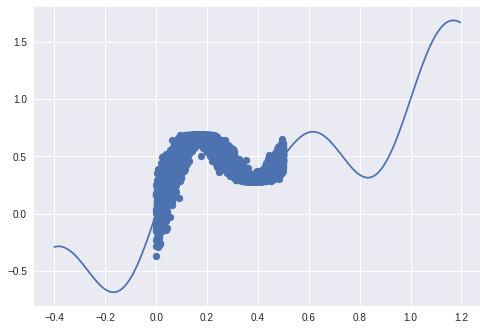

In [20]:
# Regression curves data

SAMPLE_SIZE = 6000

def noisy_function(x):
  epsilon = dist.Normal(0, 0.02).sample(torch.Size([SAMPLE_SIZE]))
  return (x + 0.3 * torch.sin(2 * math.pi * (x + epsilon)) +
          0.3 * torch.sin(4 * math.pi * (x + epsilon)) + epsilon)

def true_function(x):
  return x + 0.3 * torch.sin(2 * math.pi * x) + 0.3 * torch.sin(4 * math.pi * x)
 
trainfeatures = dist.Uniform(
    torch.tensor([0.0]), torch.tensor([0.5])).sample(torch.Size([SAMPLE_SIZE])).flatten()
trainlabels = noisy_function(trainfeatures) 

true_range = torch.arange(-0.4, 1.2, 0.005)
true_labels = true_function(true_range)

if use_cuda:
  true_range = true_range.cuda()

plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy())
plt.plot(true_range.cpu().numpy(), true_labels.flatten().cpu().numpy())
plt.plot()

trainfeatures = trainfeatures.view([SAMPLE_SIZE, 1])
trainlabels = trainlabels.view([SAMPLE_SIZE, 1])
trainset = torch.utils.data.TensorDataset(trainfeatures, trainlabels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=120,
                                          shuffle=True, num_workers=2)

loss: tensor(1309.3318, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1189.8590, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(119.4727, device='cuda:0', grad_fn=<DivBackward0>)


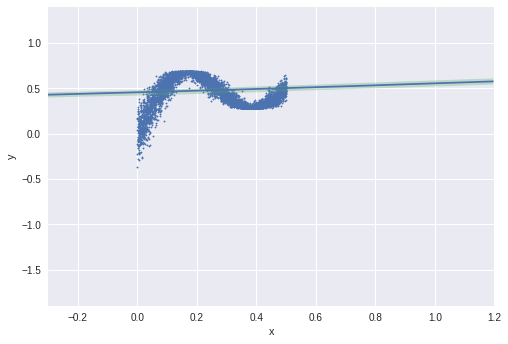

loss: tensor(1162.4182, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1160.0083, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.4099, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1132.4415, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1130.3279, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.1136, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1102.2919, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1099.7478, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.5441, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1077.3470, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1070.2773, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(7.0697, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1050.6880, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1044.3077, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(6.3802, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1015.0391, device='cuda:0', grad_fn=<AddBa

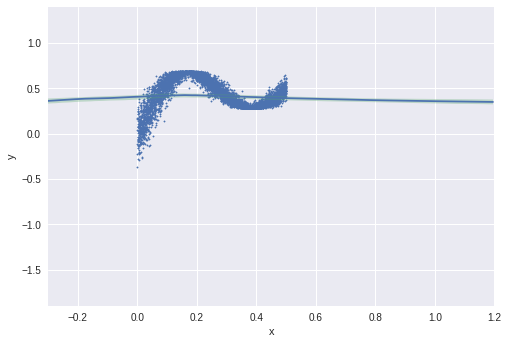

loss: tensor(872.0001, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(869.1745, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.8255, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(838.6432, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(838.7991, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.1558, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(820.1554, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(814.2732, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(5.8822, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(790.4568, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(785.2156, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(5.2412, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(761.4218, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(761.5845, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.1627, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(733.9674, device='cuda:0', grad_fn=<AddBackward0>)

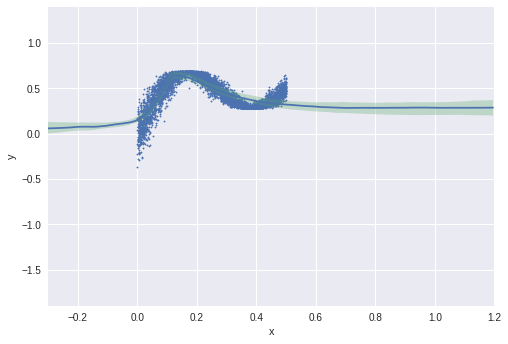

loss: tensor(617.7938, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(622.0379, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2442, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(597.3990, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(601.3581, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9591, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(572.0400, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(578.1716, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1316, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(552.3827, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(558.7686, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.3859, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(535.5005, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(540.7703, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2698, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(519.7156, device='cuda:0', grad_fn=<AddBackward

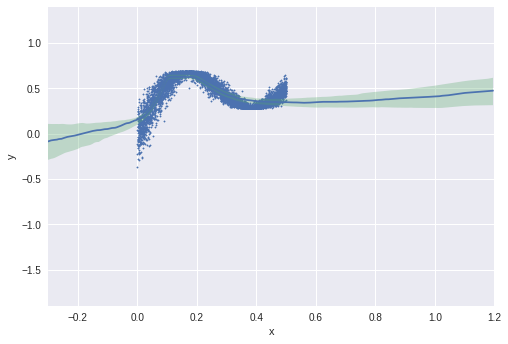

loss: tensor(437.3806, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(442.7611, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3805, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(422.2248, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(427.1400, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9152, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(407.2818, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(414.0996, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.8178, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(395.0367, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(401.6873, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.6505, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(381.6359, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(386.9262, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2903, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(372.1362, device='cuda:0', grad_fn=<AddBackward

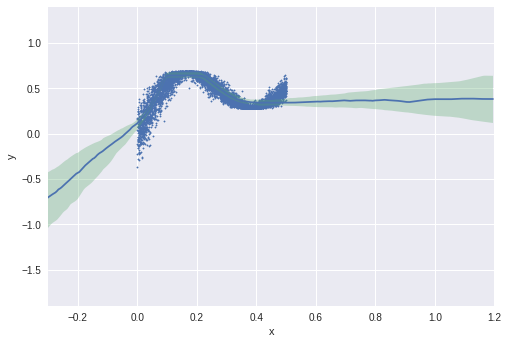

loss: tensor(319.9840, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(324.2480, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2639, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(311.6664, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(318.1260, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.4597, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(303.9573, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(310.3058, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.3485, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(292.8158, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(299.8380, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.0222, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(285.0283, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(290.8790, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8506, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(276.4420, device='cuda:0', grad_fn=<AddBackward

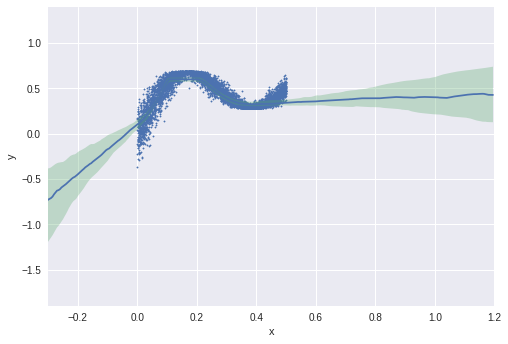

loss: tensor(243.3885, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(249.3125, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.9240, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(235.2436, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(240.1277, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8841, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(227.7343, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(234.6249, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.8906, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(224.3819, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(230.5189, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1371, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(216.9895, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(223.0191, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.0296, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(212.0830, device='cuda:0', grad_fn=<AddBackward

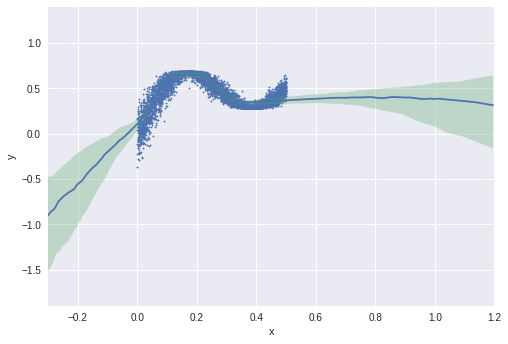

loss: tensor(192.8882, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(197.7485, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8603, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(183.0951, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(188.7117, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6166, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(179.3826, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(186.2509, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.8683, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(181.3745, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(183.8737, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4992, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(173.2427, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(179.1847, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.9420, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(171.4405, device='cuda:0', grad_fn=<AddBackward

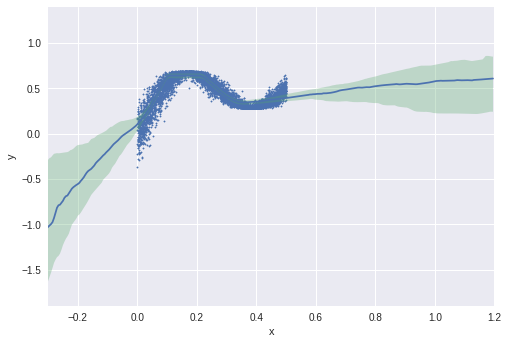

loss: tensor(149.3253, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(156.4772, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.1519, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(147.6190, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(154.1629, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.5439, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(144.1918, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(150.6284, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.4365, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(143.2972, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(151.2194, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.9222, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(138.7000, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(145.0541, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.3541, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(136.1969, device='cuda:0', grad_fn=<AddBackward

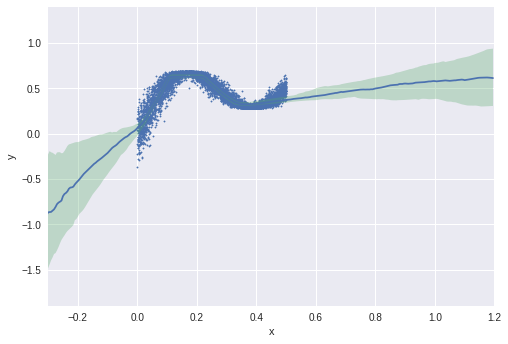

loss: tensor(120.7772, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(128.3236, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.5464, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(120.5708, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(124.1417, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5709, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(115.4422, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(122.5170, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.0748, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(113.1308, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(119.6686, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.5378, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(110.4957, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(118.0633, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.5676, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(112.3302, device='cuda:0', grad_fn=<AddBackward

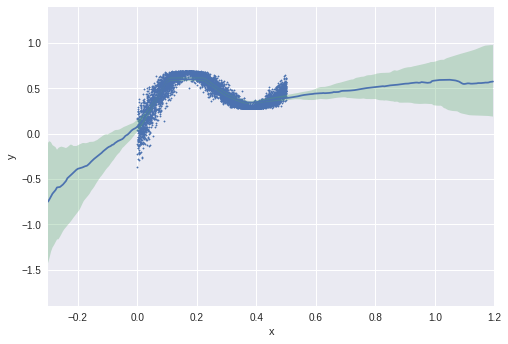

loss: tensor(100.4334, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(107.1593, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.7259, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(96.3067, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(103.8606, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.5539, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(93.1089, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(100.3681, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.2592, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(93.0257, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(99.9604, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.9347, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(91.6049, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(98.3234, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.7185, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(89.5908, device='cuda:0', grad_fn=<AddBackward0>)
kl:

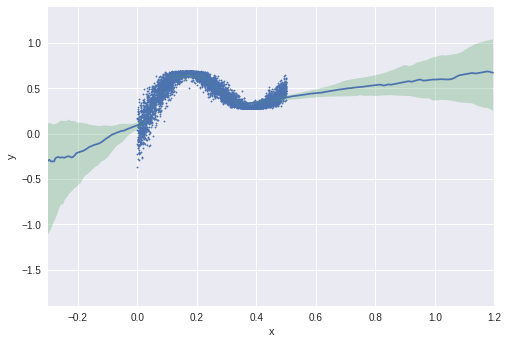

loss: tensor(80.2970, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(87.2485, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.9515, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(83.2648, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(89.1477, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8829, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(77.5988, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(84.8350, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.2362, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(75.2958, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(83.3806, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-8.0847, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(76.4155, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(83.7798, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.3643, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(75.3829, device='cuda:0', grad_fn=<AddBackward0>)
kl: ten

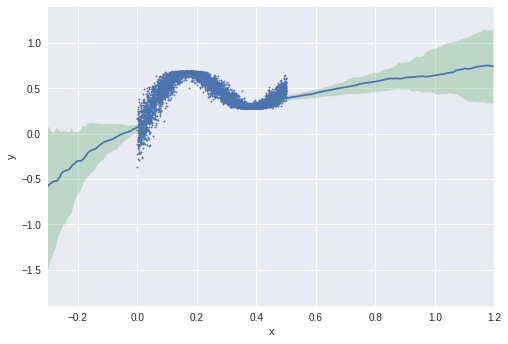

loss: tensor(70.9554, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(76.7849, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8295, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(66.5831, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(73.7097, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.1266, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(64.5436, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(72.3896, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.8460, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(64.1799, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(71.9615, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.7816, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(67.0788, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(71.3659, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2871, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(64.0910, device='cuda:0', grad_fn=<AddBackward0>)
kl: ten

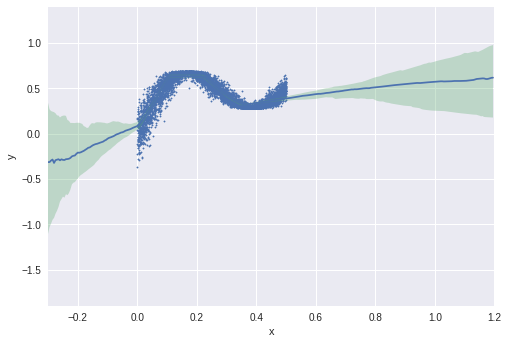

loss: tensor(58.0588, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(64.8765, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.8177, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(59.0165, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(64.5539, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.5374, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(56.9826, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(63.3445, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.3619, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(54.7036, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(61.8810, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.1774, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(54.7129, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(62.6405, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.9276, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(166.1689, device='cuda:0', grad_fn=<AddBackward0>)
kl: te

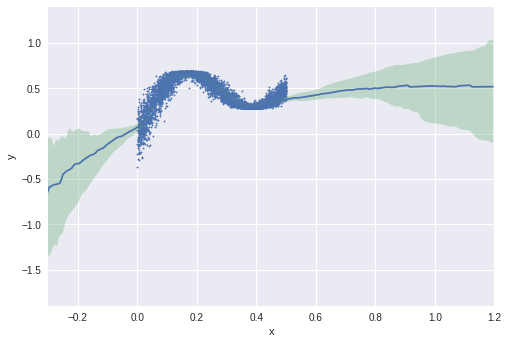

loss: tensor(49.5155, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(57.3173, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.8018, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(50.1238, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(56.7179, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.5940, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(52.5761, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(56.2840, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.7079, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(47.8377, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(54.0427, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.2050, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(50.3546, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(54.8023, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4477, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(47.4127, device='cuda:0', grad_fn=<AddBackward0>)
kl: ten

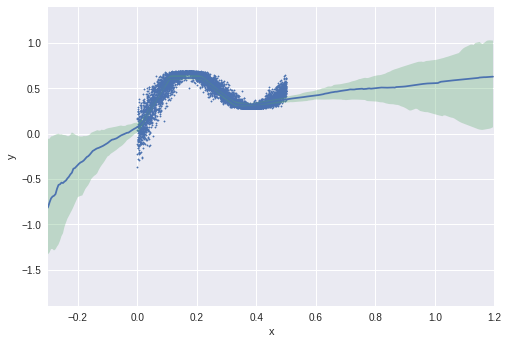

loss: tensor(43.7873, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(51.1373, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.3501, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(45.2097, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(51.6530, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.4434, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(42.8482, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(50.1566, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.3085, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(43.1529, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(49.7682, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.6153, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(41.1004, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(48.5529, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.4525, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(43.0012, device='cuda:0', grad_fn=<AddBackward0>)
kl: ten

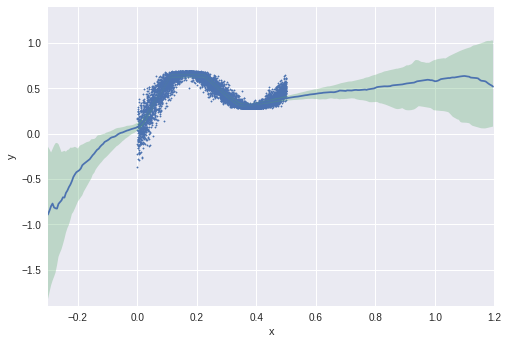

loss: tensor(39.1714, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(47.0623, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.8909, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(39.3332, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(46.3464, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.0132, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(38.2360, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(45.5365, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.3004, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(38.4192, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(45.4273, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.0082, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(39.0220, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(46.4023, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.3803, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(37.2148, device='cuda:0', grad_fn=<AddBackward0>)
kl: ten

KeyboardInterrupt: ignored

In [21]:
# Training

optimizer = optim.Adam(net.parameters(), lr=0.003)
net.train()

for epoch in range(30001):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        num_batches = len(trainloader)
        # forward + backward + optimize
        loss, kl, nll = net.cost_function(inputs, labels, num_samples=1, ratio=1/num_batches)
        if i % 100 == 0:
          print("loss:", loss)
          print("kl:", kl)
          print("nll:", nll)
        loss.backward()
        optimizer.step()
    
    if(epoch%10==0):
        net.train()
        outputs = []
        for sample_count in range(100):
          outputs.append(net(true_range.view([320, 1])))
        outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
        output_median = np.median(outputs, axis=1)
        output_lower = np.percentile(outputs, 25, axis=1)
        output_higher = np.percentile(outputs, 75, axis=1)
        plt.ylim(-1.9,1.4)
        plt.xlim(-0.3, 1.2)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.plot(true_range.flatten().cpu().numpy(), output_median)
        plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
        plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
        plt.plot()
        plt.show()

print('Finished Training')

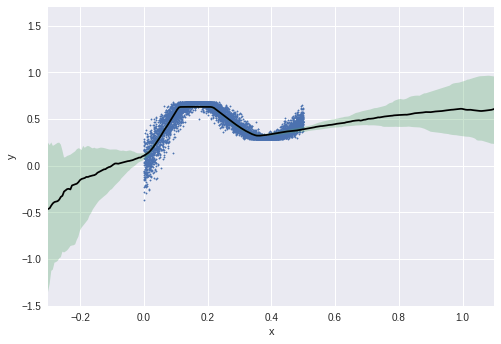

In [36]:

# generate the plot
net.train()
outputs = []
for sample_count in range(100):
  outputs.append(net(true_range.view([320, 1])))
outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
output_median = np.median(outputs, axis=1)
output_lower = np.percentile(outputs, 25, axis=1)
output_higher = np.percentile(outputs, 75, axis=1)
plt.plot(true_range.flatten().cpu().numpy(), output_median, color="black")
plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
plt.ylim(-1.5,1.7)
plt.xlim(-0.3, 1.1)
plt.xlabel("x")
plt.ylabel("y")
plt.plot()
plt.show()